In [1]:
import warnings
from typing import List, Literal, Optional, Tuple

import moscot as mt
import moscot.plotting as mtp
from moscot.problems.time import TemporalProblem
from tqdm.std import TqdmWarning

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import scanpy as sc

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", TqdmWarning)

In [2]:
adata = sc.read("/home/icb/dominik.klein/git_repos/genot_benchmarks/input_data/pancreas_data/adata_pancreas_2019_endocrine_ductal.h5ad")

In [6]:
adata.obs["day"] = adata.obs["day"].astype("float").astype("category")

In [71]:
tp = TemporalProblem(adata)
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="mouse", gene_set_apoptosis="mouse"
)
tp = tp.prepare("day", joint_attr="X_pca")
tp = tp.solve()

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


INFO     Ordering Index(['AAACCTGAGATCCCGC-1-2', 'AAACCTGCAATTGCTG-1-2', 'AAACCTGCACAGAGGT-1-2',                   
                'AAACCTGCAGACAAAT-1-2', 'AAACCTGCAGATGAGC-1-2', 'AAACCTGGTAAGGGCT-1-2',                            
                'AAACCTGGTTAAGATG-1-2', 'AAACCTGTCCAAGCCG-1-2', 'AAACCTGTCCGCGTTT-1-2',                            
                'AAACCTGTCTAAGCCA-1-2',                                                                            
                ...                                                                                                
                'TTTGGTTCACCAGATT-1-3', 'TTTGGTTCACGAAGCA-1-3', 'TTTGGTTTCACTTACT-1-3',                            
                'TTTGGTTTCCTTTCGG-1-3', 'TTTGTCAAGAATGTGT-1-3', 'TTTGTCAAGTGACATA-1-3',                            
                'TTTGTCAAGTGTGGCA-1-3', 'TTTGTCAGTTGTTTGG-1-3', 'TTTGTCATCGAATGCT-1-3',                            
                'TTTGTCATCTGTTTGT-1-3'],                                

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/moscot/problems/time/_mixins.py:986: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not (is_categorical_dtype(col) and is_numeric_dtype(col.cat.categories)):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/ann

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5934, 3696)].                                  
WARNING  Solver did not converge                                                                                   


In [72]:
_ = tp.cell_transition(14.5, 15.5, "celltype", "celltype")

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/moscot/base/problems/_mixins.py:401: FutureWa

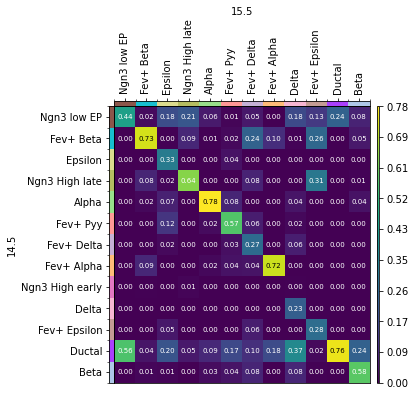

In [73]:
mtp.cell_transition(tp)

In [74]:
import jax.numpy as jnp
from typing import Any, Union
from ott.geometry import geometry, pointcloud
import jax 
from ott.geometry import costs, geometry, graph, pointcloud

def get_nearest_neighbors(
        X: jnp.ndarray, Y: jnp.ndarray, k: int = 30
    ) -> Tuple[jnp.ndarray, jnp.ndarray]:  
        concat = jnp.concatenate((X, Y), axis=0)
        pairwise_euclidean_distances = pointcloud.PointCloud(concat, concat).cost_matrix
        distances, indices = jax.lax.approx_min_k(
            pairwise_euclidean_distances, k=k, recall_target=0.95, aggregate_to_topk=True
        )
        return distances, indices

def create_cost_matrix(X: jnp.array, Y: jnp.array, k_neighbors: int, **kwargs: Any) -> jnp.array:
    distances, indices = get_nearest_neighbors(X, Y, k_neighbors)
    a = jnp.zeros((len(X) + len(Y), len(X) + len(Y)))
    adj_matrix = a.at[
        jnp.repeat(jnp.arange(len(X) + len(Y)), repeats=k_neighbors).flatten(), indices.flatten()
    ].set(distances.flatten())
    return graph.Graph.from_graph(adj_matrix, normalize=kwargs.pop("normalize", True), **kwargs).cost_matrix[:len(X), len(X):]

In [75]:
import pandas as pd
cm = create_cost_matrix(tp[14.5, 15.5].xy.data_src, tp[14.5, 15.5].xy.data_tgt, k_neighbors=10)
df_xy = pd.DataFrame(cm, index=tp[14.5, 15.5].adata_src.obs_names, columns=tp[14.5, 15.5].adata_tgt.obs_names)
tp[14.5, 15.5].set_xy(df_xy, tag="cost_matrix")

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [76]:
tp.solve()

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5934, 3696)].                                  


/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


WARNING  Solver did not converge                                                                                   


TemporalProblem[(14.5, 15.5)]

In [77]:
_ = tp.cell_transition(14.5, 15.5, "celltype", "celltype", forward=False)


/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/moscot/base/problems/_mixins.py:401: FutureWa

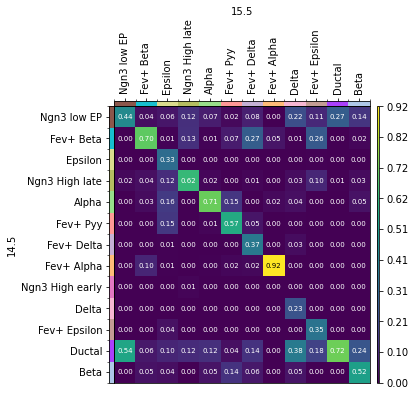

In [78]:
mtp.cell_transition(tp)

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


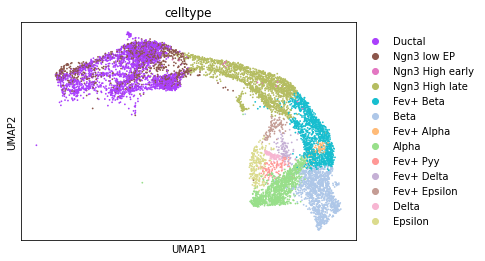

In [16]:
sc.pl.umap(adata, color="celltype")

In [17]:
adata_red = adata[~adata.obs["celltype"].isin(["Ngn3 High early", "Ngn3 High late"])].copy()

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [22]:
tp2 = TemporalProblem(adata_red)
tp2 = tp2.prepare("day", joint_attr="X_pca")
tp2 = tp2.solve()

INFO     Ordering Index(['AAACCTGAGATCCCGC-1-2', 'AAACCTGCAATTGCTG-1-2', 'AAACCTGCACAGAGGT-1-2',                   
                'AAACCTGCAGATGAGC-1-2', 'AAACCTGGTAAGGGCT-1-2', 'AAACCTGTCCAAGCCG-1-2',                            
                'AAACCTGTCCGCGTTT-1-2', 'AAACCTGTCTAAGCCA-1-2', 'AAACCTGTCTTATCTG-1-2',                            
                'AAACCTGTCTTTAGGG-1-2',                                                                            
                ...                                                                                                
                'TTTGGTTAGACAGGCT-1-3', 'TTTGGTTCAAAGCGGT-1-3', 'TTTGGTTCAAATTGCC-1-3',                            
                'TTTGGTTCACCAGATT-1-3', 'TTTGGTTTCCTTTCGG-1-3', 'TTTGTCAAGAATGTGT-1-3',                            
                'TTTGTCAAGTGACATA-1-3', 'TTTGTCAGTTGTTTGG-1-3', 'TTTGTCATCGAATGCT-1-3',                            
                'TTTGTCATCTGTTTGT-1-3'],                                

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/moscot/problems/time/_mixins.py:986: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not (is_categorical_dtype(col) and is_numeric_dtype(col.cat.categories)):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


WARNING  Solver did not converge                                                                                   


In [23]:
_ = tp2.cell_transition(14.5, 15.5, "celltype", "celltype")

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/moscot/base/problems/_mixins.py:401: FutureWa

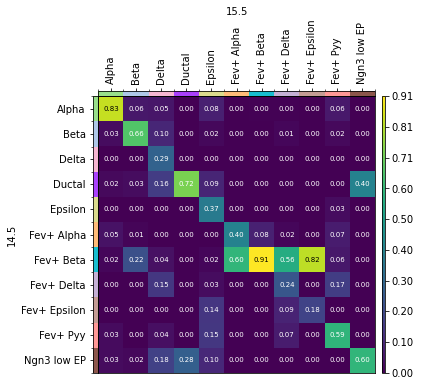

In [24]:
mtp.cell_transition(tp2)